Training Time: 0.58 seconds

Evaluation Metrics:
RMSE: 1.0172
MAE: 0.6982
R-squared: 0.9906
Explained Variance: 0.9906
Max Error: 2.8616

Cross-Validation Results (with Early Stopping):
  CV RMSE: 0.9925 (std: 0.0912)
  CV MAE: 0.6684 (std: 0.0465)
  CV R-squared: 0.9907 (std: 0.0033)


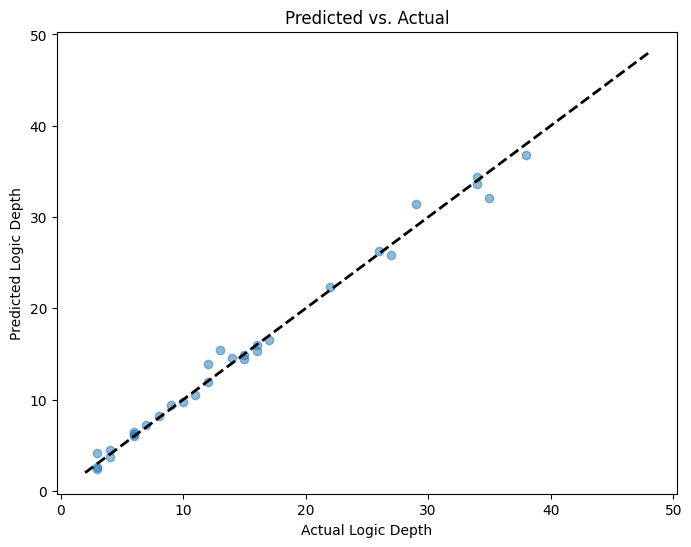

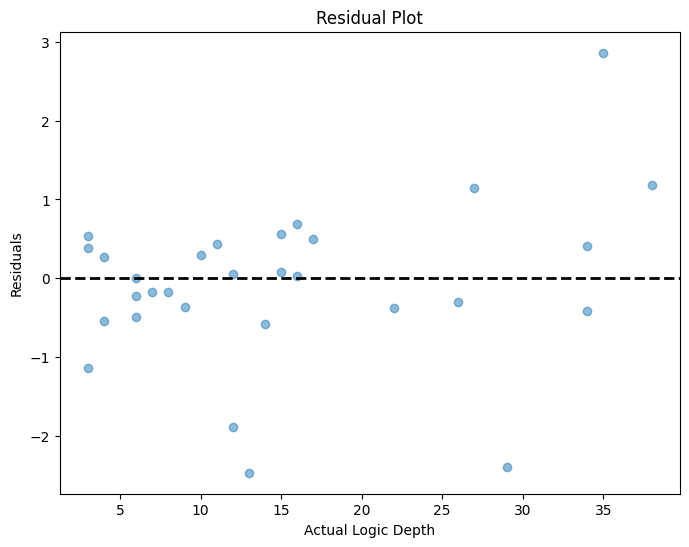

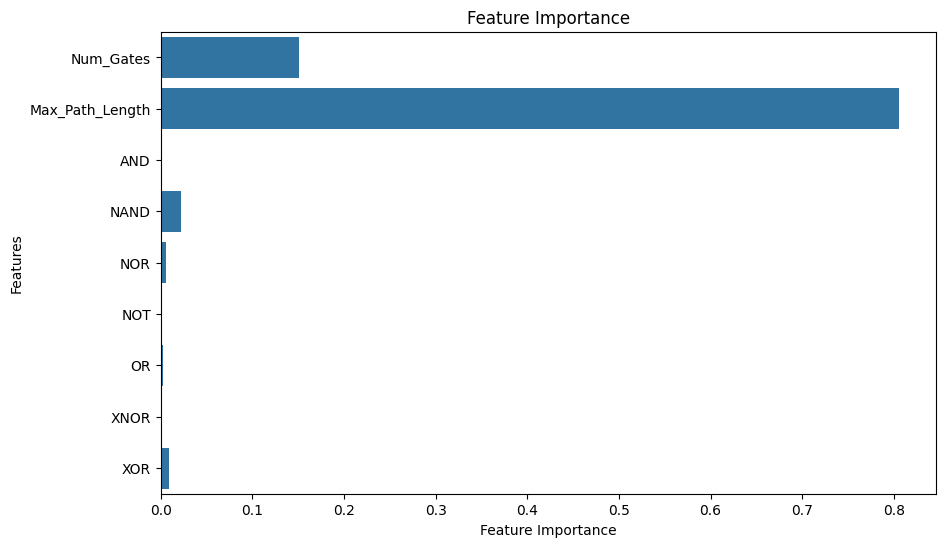


Predicted Logic Depth for New Data: 14.28


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
    max_error,
)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

# --- (Data Loading, Preprocessing, Feature Engineering - Same as before) ---
DATASET_PATH = "/content/logic_depth_dataset.csv"

try:
    data = pd.read_csv(DATASET_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {DATASET_PATH}.  Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

data.dropna(inplace=True)
data.drop('Circuit_ID', axis=1, inplace=True)
gate_types = data['Gate_Types'].str.get_dummies(sep=',')
gate_types.columns = [col.replace(' ', '_') for col in gate_types.columns]
data = pd.concat([data, gate_types], axis=1)
data.drop('Gate_Types', axis=1, inplace=True)
gate_type_features = list(gate_types.columns)
features = ['Num_Gates', 'Max_Path_Length'] + gate_type_features
X = data[features]
y = data['Logic_Depth']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- 7. Model Training (XGBoost) with Early Stopping (on final model) ---
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
)

start_time = time.time()
xgb_model.fit(
    X_train_es,
    y_train_es,
    eval_set=[(X_val_es, y_val_es)],  # Validation set for early stopping
    verbose=False,
)
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")


# --- 8. Model Evaluation (Multiple Metrics) ---

y_pred = xgb_model.predict(X_test)
metrics = {
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred),
    "R-squared": r2_score(y_test, y_pred),
    "Explained Variance": explained_variance_score(y_test, y_pred),
    "Max Error": max_error(y_test, y_pred),
}

print("\nEvaluation Metrics:")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")


# --- 9. Cross-Validation (WITH Early Stopping) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
mae_scores = []
r2_scores = []

for train_index, val_index in kf.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Create a *new* XGBoost model for each fold
    xgb_model_fold = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,  # High n_estimators, rely on early stopping
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50,
    )

    # Train with early stopping *within* the fold
    xgb_model_fold.fit(
        X_train_fold,
        y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],  # Use the fold's validation set
        verbose=False,
    )

    # Make predictions and evaluate
    y_pred_fold = xgb_model_fold.predict(X_val_fold)
    rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_fold)))
    mae_scores.append(mean_absolute_error(y_val_fold, y_pred_fold))
    r2_scores.append(r2_score(y_val_fold, y_pred_fold))

print("\nCross-Validation Results (with Early Stopping):")
print(f"  CV RMSE: {np.mean(rmse_scores):.4f} (std: {np.std(rmse_scores):.4f})")
print(f"  CV MAE: {np.mean(mae_scores):.4f} (std: {np.std(mae_scores):.4f})")
print(f"  CV R-squared: {np.mean(r2_scores):.4f} (std: {np.std(r2_scores):.4f})")

# --- 10. Visualization (Same as before) ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Logic Depth")
plt.ylabel("Predicted Logic Depth")
plt.title("Predicted vs. Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.xlabel("Actual Logic Depth")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_model.feature_importances_, y=features)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

# --- 11. Prediction on New Data (Same as before) ---
new_data_dict = {
    'Num_Gates': [30],
    'Max_Path_Length': [15],
    'NAND': [10],
    'XNOR': [5],
    'NOT': [5],
    'AND': [5],
    'OR': [3],
    'XOR': [2],
    'NOR': [0]
}

for col in gate_type_features:
    if col not in new_data_dict:
        new_data_dict[col] = [0]

new_data = pd.DataFrame(new_data_dict)
new_data = new_data[features]
new_data_scaled = scaler.transform(new_data)
predicted_depth = xgb_model.predict(new_data_scaled)
print(f"\nPredicted Logic Depth for New Data: {predicted_depth[0]:.2f}")